In [93]:
import sys # for automation and parallelization
manual, scenario = (True, 'project_office') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [94]:
import pandas as pd
sys.path.insert(0, '../../../quetzal')
from quetzal.model import stepmodel
from quetzal.io import importer
from quetzal.io import road as road_io
from quetzal.io import excel
from syspy.spatial.spatial import nearest_geometry, nearest
import geopandas as gpd
import shapely
import fiona
fiona.supported_drivers['KML'] = 'rw'

In [95]:
# the scenario specific variables are read from the parameter file
var = excel.read_var(file='../../inputs/parameters.xlsx', scenario=scenario)

# roads

In [96]:
road_layer_path = '../../inputs/roads/' + var['general']['roads_layer_name'] + '.geojson'
road_links, road_nodes = road_io.get_links_and_nodes(road_layer_path)
road_links['factor']=1
road_links.loc[road_links['highway']== 'residential', 'factor'] = 1.2
road_links['length'] = road_links.length * road_links['factor']

#Poner los type de cada escenarioooooooo !!!!!!!!!!!! /!\

# lines

In [97]:
sm20137 = stepmodel.StepModel(epsg=20137, coordinates_unit='meter')

In [98]:
routes_layer_path = '../../inputs/lines/' + var['general']['routes_layer_name'] + '.geojson'
routes = gpd.read_file(routes_layer_path)
stops = gpd.read_file(r'../../inputs/lines/stops_20137.geojson')
stops['intindex'] = stops.index
stops.index = stops['name'].fillna(stops['intindex'])
stops.index = [str(i) for i in stops.index]

In [99]:
routes_code = var['general']['routes_code']
routes = routes.loc[routes['mode_' + routes_code] != '0']

In [100]:
def multilinestring_to_linestring(g):
    try: 
        return g[0]
    except TypeError: #'LineString' object is not subscriptable
        return g
    
routes['geometry'] = routes['geometry'].apply(multilinestring_to_linestring)

In [101]:
def match_lines_on_nodes(lines, nodes, tolerance=1, keep_anchors=False):
    lines = lines.copy()
    nodes = nodes.copy()
    anchors = set()
    for g in lines['geometry']:
        for a in g.coords:
            anchors.add(a)

    one = pd.DataFrame({'geometry':{a: shapely.geometry.Point(a) for a in anchors}})
    nodes.index = [tuple(g.coords[0]) for g in nodes['geometry']]
    many = nodes
    near = nearest(one, many, n_neighbors=5)
    tolerance = 1 # m
    near = near.loc[near['distance'] < tolerance]
    coords_swap = near.set_index('ix_one')['ix_many'].to_dict()
    
    def remove_anchors(linestring, coords_swap):
        coords = [
            coords_swap.get(c, c)
            for c in linestring.coords 
            if c in coords_swap or keep_anchors
        ]
        return shapely.geometry.LineString(coords)

    lines['geometry'] = lines['geometry'].apply(lambda g: remove_anchors(g, coords_swap))
    return lines

def links_from_lines_and_nodes(lines, nodes):
    lines = match_lines_on_nodes(lines, nodes)
    links, n = importer.from_lines(lines, add_return=True)

    right = {tuple(g.coords[0]): i for i, g in nodes['geometry'].to_dict().items()} # {coords: index}
    node_dict = {i: right[tuple(g.coords[0])] for i, g in n['geometry'].to_dict().items()}
    links['a'] = links['a'].apply(lambda i: node_dict[i])
    links['b'] = links['b'].apply(lambda i: node_dict[i])
    return links

In [102]:
routes.set_index('id', inplace=True)
routes.index = [str(i) for i in routes.index]
routes['route_id'] = routes.index
links = links_from_lines_and_nodes(routes, stops)
nodes = stops

# merge stops and routes

In [103]:
links = pd.merge(links, routes.drop('geometry', axis=1), on='route_id')

# merge road and pt network 
work on projejections (CRS)

In [104]:
sm20137.links = links
sm20137.nodes = nodes
sm20137.road_links = road_links
sm20137.road_nodes = road_nodes
sm = sm20137.copy()

# remove links that are outside of the road network

In [105]:
hull = shapely.geometry.MultiPoint(list(sm.road_nodes['geometry'])).convex_hull.buffer(1e-3)
sm.nodes = sm.nodes.loc[sm.nodes['geometry'].apply(lambda g: hull.contains(g))]

In [106]:
sm.integrity_fix_nodeset_consistency()
dump_on_demand = sm.copy()

In [107]:
sm.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=10, 
    n_neighbors=7,
    weight='length',
    penalty_factor=1,
)

12_bis: 100%|██████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.41it/s]


In [108]:
sm.integrity_fix_collision(prefixes={'links':'link_'})

In [109]:
sm.integrity_test_collision(sets=['nodes', 'links', 'zones', 'road_links', 'road_nodes'])

In [110]:
sm.links['length'] = sm.links['geometry'].apply(lambda g: g.length)

In [111]:
routes_code = var['general']['routes_code']
l = sm.links.copy()
l['route_type'] = l['mode_' + routes_code]
l['mode'] = l['mode_' + routes_code]
l = l.loc[l['route_type'] != '0']
sm.links = l
    
sm.to_zippedpickles('../../model/{scen}/networks'.format(scen=scenario))

networkcaster: 100%|███████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 20.58it/s]


<AxesSubplot:>

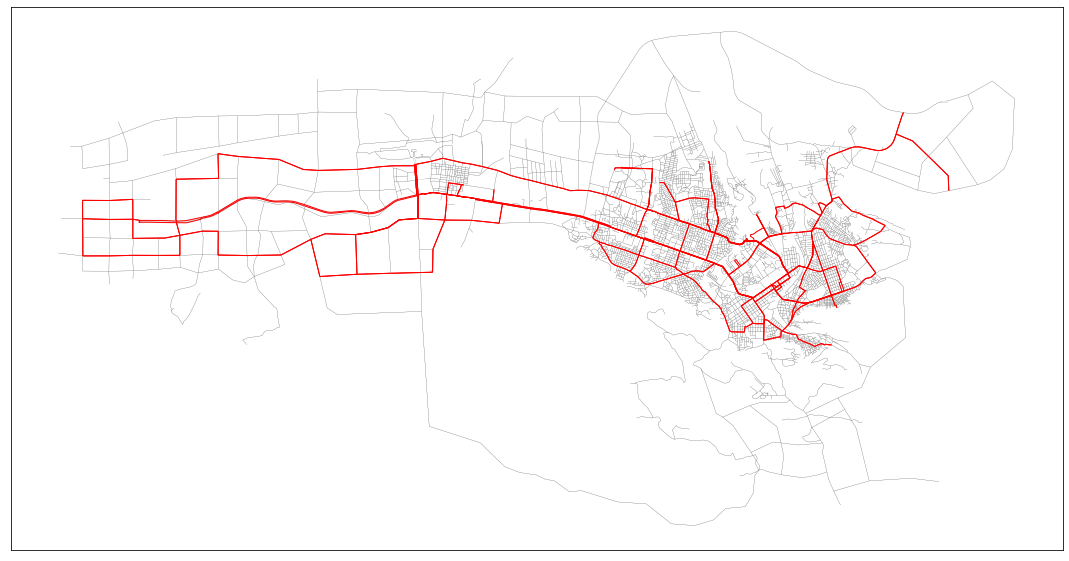

In [112]:
ax = sm.plot('road_links', figsize=[20,10], color='grey', linewidth=0.2)
sm.plot('links', ax=ax, color='red', linewidth=1)

Deprecated: replaced by analysis_lines


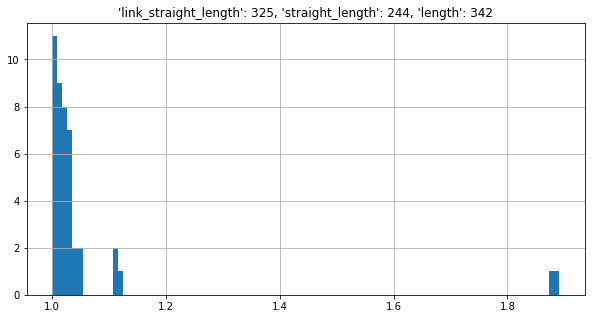

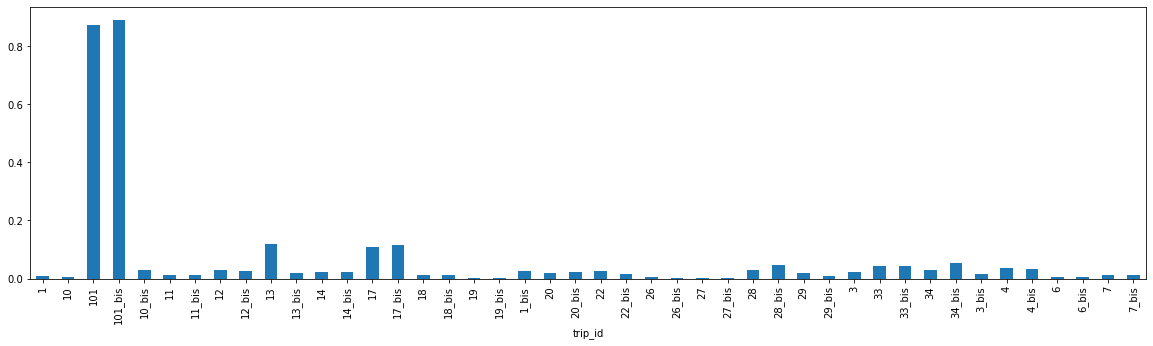

In [113]:
if manual:
    import matplotlib.pyplot as plt
    road = sm.copy()
    from shapely.geometry import LineString

    links = road.links
    links['link_straight_length'] = links['geometry'].apply(
        lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
    )
    links['length'] = links['geometry'].apply(lambda g: g.length)

    road.build_lines(force_linestring=True,sum_columns=['link_straight_length', 'length'])
    lines = road.lines
    lines['straight_length'] = lines['geometry'].apply(
        lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
    )

    lines['length_ratio'] = lines['length']/lines['link_straight_length']
    # summary
    title = str(
        (lines[['link_straight_length', 'straight_length', 'length']].sum() / 1000).astype(int).to_dict()
    )[1:-1]
    ax = lines['length_ratio'].hist(bins=100, figsize=[10, 5])
    ax.set_title(title)
    plt.show()
    
    lines['delta'] = lines['length_ratio'] - 1
    lines.set_index('trip_id')['delta'].plot(kind='bar', figsize=[20,5])

In [114]:
links_review = links.groupby(['route_id']).agg({
    'length' : 'max',
    'link_sequence' : 'max'
})
    
links_review['#links'] = links_review['link_sequence']+1

links_review

,length,link_sequence,#links
route_id,,,
1,1364.928170,43,44
10,406.393645,17,18
101,3489.276015,4,5
11,264.387423,15,16
12,362.774023,16,17
13,773.159760,12,13
14,414.472531,14,15
17,1745.295482,13,14
18,439.457565,13,14


In [115]:
links.loc[(links['route_id']=='17') & (links['direction_id']==0)]

,a,b,link_sequence,direction_id,line,trip_id,route_id,mode,mode_scat,mode_poly,...,length,mode_poly1a,road_a,road_b,road_node_list,road_link_list,road_length,geometry,route_type,link_straight_length
link_398,134,140,0,0,17,17_bis,17,local,small,local,...,1044.891414,local,road_node_5319,road_node_836,"[road_node_5319, road_node_836]",[road_link_7785],1044.891414,"LINESTRING (801414.773 1062929.560, 801661.399...",local,1044.891414
link_399,140,137,1,0,17,17_bis,17,local,small,local,...,1016.982870,local,road_node_836,road_node_4510,"[road_node_836, road_node_4510]",[road_link_7787],1016.982870,"LINESTRING (801661.399 1061914.191, 802676.536...",local,1016.982870
link_400,137,218,2,0,17,17_bis,17,local,small,local,...,922.274568,local,road_node_4510,road_node_5386,"[road_node_4510, road_node_5386]",[road_link_7789],922.274568,"LINESTRING (802676.536 1061975.437, 803598.405...",local,922.274568
link_401,218,141,3,0,17,17_bis,17,local,small,local,...,815.267155,local,road_node_5386,road_node_3324,"[road_node_5386, road_node_3324]",[road_link_7791],815.267155,"LINESTRING (803598.405 1062002.768, 804413.431...",local,815.267155
link_402,141,mateo,4,0,17,17_bis,17,local,small,local,...,327.468556,local,road_node_3324,road_node_4638,"[road_node_3324, road_node_4638]",[road_link_7792],327.468556,"LINESTRING (804413.431 1062022.621, 804740.768...",local,327.468556
link_403,mateo,quentin,5,0,17,17_bis,17,local,small,local,...,631.734527,local,road_node_4638,road_node_958,"[road_node_4638, road_node_958]",[road_link_7793],631.734527,"LINESTRING (804740.768 1062031.905, 804752.713...",local,631.734527
link_404,quentin,143,6,0,17,17_bis,17,local,small,local,...,856.810587,local,road_node_958,road_node_874,"[road_node_958, road_node_874]",[road_link_7794],856.810587,"LINESTRING (804752.713 1062663.526, 805076.217...",local,856.810587
link_405,143,327,7,0,17,17_bis,17,local,small,local,...,429.555118,local,road_node_874,road_node_1680,"[road_node_874, road_node_1680]",[road_link_15410],429.555118,"LINESTRING (805076.217 1063456.917, 805118.609...",local,429.555118
link_406,327,Melka jebdu,8,0,17,17_bis,17,local,small,local,...,274.903855,local,road_node_1680,road_node_2384,"[road_node_1680, road_node_2384]",[road_link_3753],329.884626,"LINESTRING (805118.609 1063884.376, 805126.516...",local,274.593600
link_407,Melka jebdu,center_melka,9,0,17,17_bis,17,local,small,local,...,335.352978,local,road_node_2384,road_node_5120,"[road_node_2384, road_node_4017, road_node_342...","[road_link_11415, road_link_11426, road_link_3...",399.355325,"LINESTRING (805122.302 1064158.944, 805137.480...",local,320.132943
